## LeNet-5
> `합성곱(convolutional)`과 `다운 샘플링(sub-sampling)`(혹은 풀링)을 반복적으로 거치면서 마지막 완전연결층에서 분류를 수행함.<p>
C1 5X5 합성곱 연산 후 28X28 크기의 특성 맵(feature map) 6개를 생성. S2에서 다운샘플링하여 특성 맵 크기를 14X14로 축소.<p>
다시 C3에서 5X5 합성곱 연산하여 10X10 크기의 특성 맵 16개를 생성, S4에서 다운 샘플링하여 특성 맵 크기를 5X5로 축소. <p>
C5에서 5X5 합성곱 연산하여 1X1 크기의 특성 맵 120개를 생성하고, 마지막으로 F6에서 완전연결층으로 C5 결과를 유닛(또는 노드) 84개에 연결시킴. <p> ** 여기서 C는 합성곱층, S는 풀링층을 의미. F는 완전연결층을 의미 **

|계층 유형|특성 맵|크기|커널 크기|스트라이드|활성화 함수|
|------|---|---|---|---|---|
|이미지|1|32X32|-|-|-|
|합성곱층|6|28X28|5X5|1|ReLU|
|최대 풀링층|6|14X14|2X2|2|-|
|합성곱층|16|10X10|5X5|1|ReLU|
|최대 풀링층|16|5X5|2X2|2|-|
|완전연결층|-|120|-|-|ReLU|
|완전연결층|-|84|-|-|ReLU|
|완전연결층|-|2|-|-|Softmax|

In [30]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# data preprocessing
class ImageTransform() : 
    def __init__(self, resize, mean, std) :
        self.data_transform = {
            'train' : transforms.Compose([
                    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                # scale=(0.5, 1.0) : 랜덤 크기 50~100% 리사이징
                    transforms.RandomHorizontalFlip(), # 수평 반전
                    transforms.ToTensor(), # (H, W, C) --> (C, H, W)
                    transforms.Normalize(mean ,std) # 정규화
                # mean (0.485, 0.456, 0.406), std (0.229, 0.224, 0.225)
                # ---> ImageNet의 이미지 RGB 채널마다 평균과 표준편차를 의미
            ]),
            'val' : transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase) :
        return self.data_transform[phase](img)

In [4]:
# 데이터셋 로드 후 train, test ,validation 분리
cat_dir = r'../080289-main/chap06/data/dogs-vs-cats/Cat/'
dog_dir = r'../080289-main/chap06/data/dogs-vs-cats/Dog/'

cat_img_filepath = sorted([os.path.join(cat_dir, f)  for f in os.listdir(cat_dir)])
dog_img_filepath = sorted([os.path.join(dog_dir, f) for f in os.listdir(dog_dir)])

img_filepath = [*cat_img_filepath, *dog_img_filepath]
correct_img_filepath = [i for i in img_filepath if cv2.imread(i) is not None]

random.seed(12)
random.shuffle(correct_img_filepath)
train_img_filepath = correct_img_filepath[:400] # train 400
val_img_filepath = correct_img_filepath[400:-10] # val 92
test_img_filepath = correct_img_filepath[-10:] # test 10
print(len(train_img_filepath), len(val_img_filepath), len(test_img_filepath))

400 92 10


In [5]:
# 테스트 데이터셋 이미지 확인
def display_img_grid(img_filepath, pred_labels=(), cols=5) :
    rows = len(img_filepath) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, img_filepath in enumerate(img_filepath) :
        image = cv2.imread(img_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(img_filepath).split(os.sep)[-2]
        pred_label = pred_labels[i] if pred_labels else true_label
        color = 'green' if true_label == pred_label else 'red'
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(pred_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

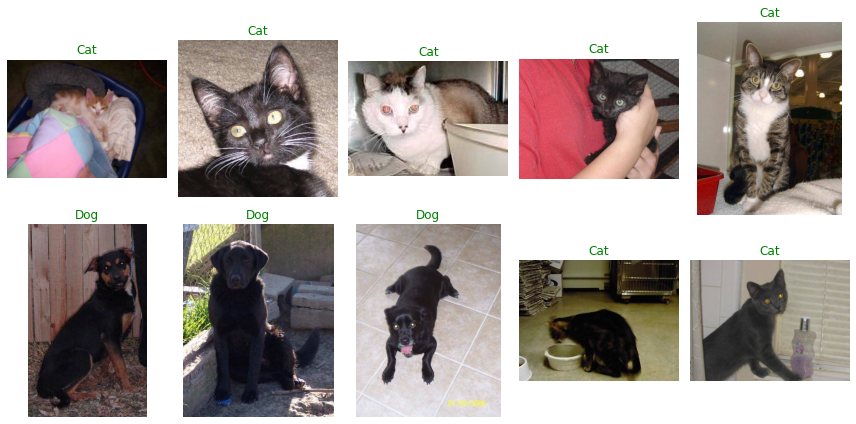

In [6]:
display_img_grid(test_img_filepath)

In [10]:
# 이미지 데이터셋 클래스 정의
class DogvsCatDataset(Dataset) :
    def __init__(self, file_list, transform=None, phase='train') :
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self) :
        return len(self.file_list)
    
    def __getitem__(self, idx) :
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog' :
            label = 1
        elif label == 'cat' :
            label = 0 
        return img_transformed, label

In [8]:
# 변수 값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [11]:
# 이미지 데이터셋 정의
train_dataset = DogvsCatDataset(train_img_filepath, transform=ImageTransform(size, mean, std),
                               phase='train')
val_dataset = DogvsCatDataset(val_img_filepath, transform=ImageTransform(size, mean, std),
                             phase='val')
index = 0
print(train_dataset.__getitem__(index)[0].size()) # 훈련 데이터의 크기 출력
print(train_dataset.__getitem__(index)[1]) # 레이블 출력

torch.Size([3, 224, 224])
1


In [12]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train' : train_dataloader, 'val' : val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 0])


In [21]:
# 네트워크 클래스
class LeNet(nn.Module) :
    def __init__(self) :
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, 
                             kernel_size=5, stride=1, padding=0) # (16, 220 ,220)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # (16, 110 ,110)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5,
                             stride=1, padding=0) # (32, 106, 106)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) # (32, 53, 53)
        
        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)
        
    def forward(self, x) :
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

### Conv2d 계층 출력 크기 공식
output size = (W-F+2P) / S+1
> W : 입력 데이터 크기 / F : 커널 크기 / P : 패딩 크기 / S : 스트라이드

### MaxPool2d 계층 출력 크기 공식
output size = IF / F 
> IF : 입력 필터 크기 / F : 커널 크기

In [22]:
model = LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [23]:
# !pip install torchsummary
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [24]:
# 학습 가능한 파라미터 확인
def count_params(model) :
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Model has {count_params(model):,} trainable parameters')

Model has 46,038,242 trainable parameters


In [26]:
# define optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [27]:
# 모델의 파라미터와 손실함수를 디바이스에 할당
model = model.to(device)
criterion = criterion.to(device)

In [32]:
# define train function 
def train_model(model, dataloader_dict, criterion, optimizer, n_epochs) :
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(n_epochs) : 
        print(f'Epoch {epoch+1}/{n_epochs}')
        print('-' * 20)
        
        for phase in ['train', 'val'] :
            if phase == 'train' :
                model.train()
                
            else :
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]) :
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() # 기욹 ㅣ초기화
                
                with torch.set_grad_enabled(phase == 'train') :
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train' :
                        loss.backward()
                        optimizer.step()
                    
                    # 손실 함수는 오차를 배치크기로 나누어 평균을 반환하므로, 
                    # epoch_loss 계산 시 loss.item()과 inputs.size()를 곱하여 줌
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
                epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
                epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
                
                print(f'{phase} Loss : {epoch_loss:.4f} Acc : {epoch_acc:.4f}')
                    

                if phase == 'val' and epoch_acc > best_acc :
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                        
        time_elapsed = time.time() - since
        print(f'Training complete in : {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val acc : {best_acc:4f}')
        
        return model
                    

In [36]:
import time

n_epochs = 10
model = train_model(model, dataloader_dict, criterion, optimizer, 13)

Epoch 1/10
--------------------


C:\Users\PC\anaconda3\envs\yeseul\lib\site-packages\ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.0562 Acc : 0.0475
train Loss : 0.0503 Acc : 0.1000
train Loss : 0.0574 Acc : 0.1375
train Loss : 0.0563 Acc : 0.1800
train Loss : 0.0538 Acc : 0.2225
train Loss : 0.0578 Acc : 0.2575
train Loss : 0.0570 Acc : 0.3025
train Loss : 0.0556 Acc : 0.3475
train Loss : 0.0550 Acc : 0.3900
train Loss : 0.0535 Acc : 0.4400
train Loss : 0.0523 Acc : 0.4950
train Loss : 0.0544 Acc : 0.5425
train Loss : 0.0258 Acc : 0.5725


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.2554 Acc : 0.1630
val Loss : 0.2461 Acc : 0.3370
val Loss : 0.2162 Acc : 0.5217
Training complete in : 0m 9s
Best val acc : 0.521739


In [38]:
# 모델 테스트 함수 정의
import pandas as pd

id_list = []
pred_list = []
_id = 0

with torch.no_grad() : 
    for test_path in tqdm(test_img_filepath) :
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)
        
        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])
        
        res = pd.DataFrame({
                'id' : id_list,
                'label' : pred_list
        })
        
        res.sort_values(by='id', inplace=True)
        res.reset_index(drop=True, inplace=True)
        
        res.to_csv('./LeNet.csv', index=False)

C:\Users\PC\anaconda3\envs\yeseul\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/10 [00:00<?, ?it/s]

In [39]:
res.head()

,id,label
0,102,0.629993
1,115,0.475355
2,164,0.624156
3,175,0.616270
4,18,0.444116


In [40]:
# 테스트 데이터셋의 이미지 출력
class_ = classes = {0 : 'cat', 1 : 'dog'}

def display_img_grid(images_filepath, pred_labels=(), cols=5) :
    rows = len(images_filepath) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, images_filepath in enumerate(images_filepath) :
        image = cv2.imread(images_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        
        if label > 0.5 :
            label = 1
            
        else : 
            label = 0
            
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    
    plt.tight_layout()
    plt.show()

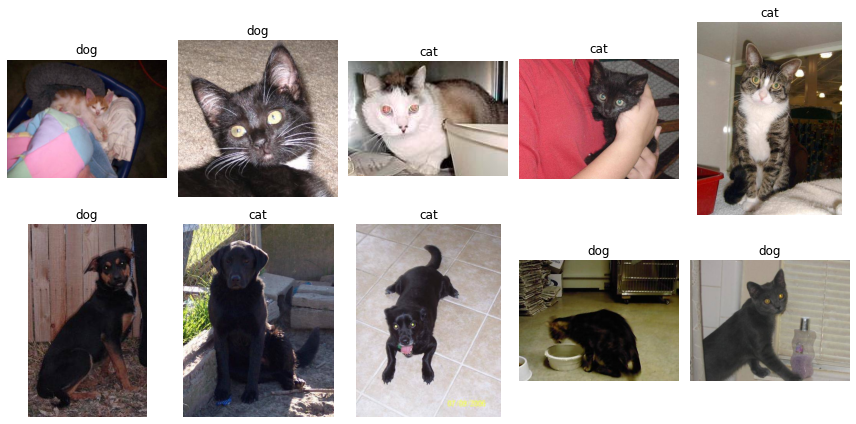

In [41]:
display_img_grid(test_img_filepath)